In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats

import thinkstats2
import thinkplot

from idealista.resources.automate_ploting import plot_continuous_distributions
from idealista.resources.find_best_fit import (find_best_distribution, calculate_pdf, 
                                               calculate_edf, find_best_fit_based_ks,
                                               calculate_cdf)

In [2]:
plt.style.use('seaborn')
colors = sns.color_palette('colorblind')
colors

[(0.00392156862745098, 0.45098039215686275, 0.6980392156862745),
 (0.8705882352941177, 0.5607843137254902, 0.0196078431372549),
 (0.00784313725490196, 0.6196078431372549, 0.45098039215686275),
 (0.8352941176470589, 0.3686274509803922, 0.0),
 (0.8, 0.47058823529411764, 0.7372549019607844),
 (0.792156862745098, 0.5686274509803921, 0.3803921568627451),
 (0.984313725490196, 0.6862745098039216, 0.8941176470588236),
 (0.5803921568627451, 0.5803921568627451, 0.5803921568627451),
 (0.9254901960784314, 0.8823529411764706, 0.2),
 (0.33725490196078434, 0.7058823529411765, 0.9137254901960784)]

## Load data houses_Madrid.csv from kaggle

In [3]:
df = pd.read_csv('data/houses_Madrid.csv', index_col=[0])
df.shape

(21742, 57)

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 21742 entries, 0 to 21741
Data columns (total 57 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   id                            21742 non-null  int64  
 1   title                         21742 non-null  object 
 2   subtitle                      21742 non-null  object 
 3   sq_mt_built                   21616 non-null  float64
 4   sq_mt_useful                  8228 non-null   float64
 5   n_rooms                       21742 non-null  int64  
 6   n_bathrooms                   21726 non-null  float64
 7   n_floors                      1437 non-null   float64
 8   sq_mt_allotment               1432 non-null   float64
 9   latitude                      0 non-null      float64
 10  longitude                     0 non-null      float64
 11  raw_address                   16277 non-null  object 
 12  is_exact_address_hidden       21742 non-null  bool   
 13  s

### Purpose of the data:

In [5]:
(df.loc[:, 'operation'].unique(), 
 df.loc[:, 'is_buy_price_known'].unique(), 
 df.loc[:, 'is_rent_price_known'].unique(),
 df.loc[:, 'house_type_id'].unique(), )

(array(['sale'], dtype=object),
 array([ True]),
 array([False]),
 array(['HouseType 1: Pisos', 'HouseType 4: Dúplex', nan,
        'HouseType 5: Áticos', 'HouseType 2: Casa o chalet'], dtype=object))

It's easy to see that the data source is a website like idealista. 
Also, it can be confirmed that all properties in the dataset are for sale, 
and there are 4 types of real-estate product.

For the first part of the analysis, there going to be picked the following features:
- sq_mt_built
- n_rooms
- n_bathrooms
- raw_address, and also title and subtitle for NPL
- is_exact_address_hidden
- neighborhood_id
- house_type_id
- built_year

In [6]:
features_selected = ['title','subtitle','sq_mt_built','n_rooms','n_bathrooms',
                     'raw_address','is_exact_address_hidden','neighborhood_id',
                     'house_type_id','built_year', 'buy_price']
new_df = df.loc[:, features_selected]
new_df.describe()

,sq_mt_built,n_rooms,n_bathrooms,built_year,buy_price
count,21616.000000,21742.000000,21726.000000,10000.000000,2.174200e+04
mean,146.920892,3.005749,2.091687,1970.046400,6.537356e+05
std,134.181865,1.510497,1.406992,69.386705,7.820821e+05
min,13.000000,0.000000,1.000000,1723.000000,3.600000e+04
25%,70.000000,2.000000,1.000000,1957.000000,1.980000e+05
50%,100.000000,3.000000,2.000000,1970.000000,3.750000e+05
75%,162.000000,4.000000,2.000000,1994.000000,7.636000e+05
max,999.000000,24.000000,16.000000,8170.000000,8.800000e+06


Additionally, it can be noted that there are 126 different neighborhood_ids

In [7]:
len(new_df['neighborhood_id'].unique())

126

So, let's first explore these features separately one by one, and then explore if there is any pattern or relation between them.

## 1. Square Meter Built

In [8]:
sq_mt_built = new_df.loc[:,'sq_mt_built']
sq_mt_built.describe()

count    21616.000000
mean       146.920892
std        134.181865
min         13.000000
25%         70.000000
50%        100.000000
75%        162.000000
max        999.000000
Name: sq_mt_built, dtype: float64

In [9]:
sq_mt_built.dropna(inplace=True)
sq_mt_built.isnull().sum()

0

`plot_distribution` is a handly function that can help and automate the distribution visualizations of the features,
in this case, the property square meter built containing in the dataset.

'plot_continuous_distributions'  420.67 ms


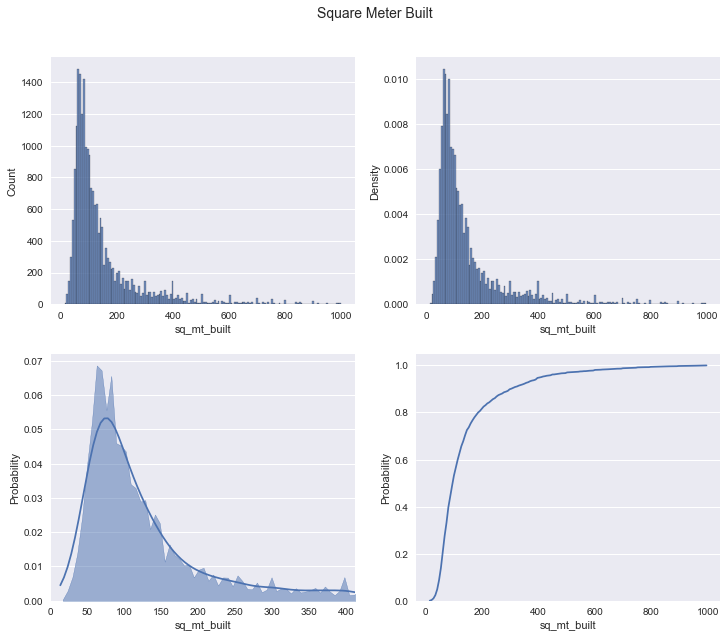

In [10]:
plot_continuous_distributions(sq_mt_built, 'Square Meter Built')

Let's discover if there is a statistical distribution that "sq_mt_built" can fit with.

`fin_best_fit_based_ks` is a function based on Kolmogorov-Smirnov statistical test. It uses scipy package to perform the calculations and estimations to figure out what is the distibution that best fit with the data input, in this case with sq_mt_built.

Its output is a map that contain valuable info related to the K-S test:

`{
    'distribution': 
    'd_statistic': 
    'p_value': 
    'params':
 }
 `

In [11]:
test_results = find_best_fit_based_ks(sq_mt_built.values)
test_results

  0%|          | 0/101 [00:00<?, ?it/s]

{'distribution': 'johnsonsu',
 'd_statistic': 0.01863349802308778,
 'p_value': 5.973609620605609e-07,
 'params': (-1.7466824060289992,
  0.914051559872858,
  44.55522615905206,
  17.261716167682188)}

In [12]:
test_results['d_crit_value'] = 1.36/np.sqrt(sq_mt_built.shape[0])

x_sorted = sq_mt_built.sort_values().values
pdf_x, pdf_y = calculate_pdf(distribution_name=test_results['distribution'],
                             params=test_results['params'],
                             size=sq_mt_built.shape[0])
edf = calculate_edf(data=sq_mt_built.values)
cdf = calculate_cdf(data=x_sorted, 
                    distribution_name=test_results['distribution'], 
                    params=test_results['params'])
pdf = pd.Series(pdf_x, pdf_y)

The following graph shows the best theoretical distribution found against the actual observations, which it helps to roughly see how similar the are.

Visually, it can be noted that they approximately overlap, however some indicators such as the p_value and R^2 can be more informative:
- p_value = 5.973609620605609e-07 < 0.05. Theoretically, if p < 0.05 it can be infered that the observations don't fit the best distribution found.
- R^2 = 0.8811, which means that just about the 88% of the observation can be modeled through the distribution found
- R = 0.9386618633237876

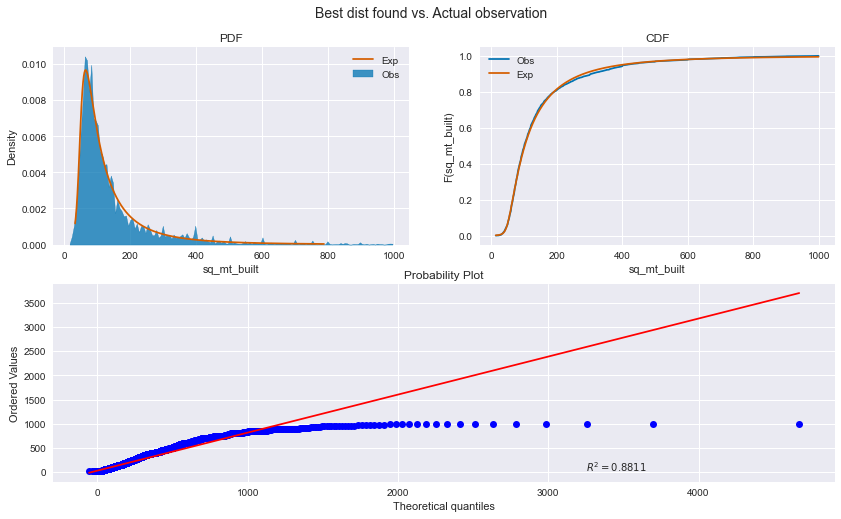

In [13]:
_ = plt.figure(figsize=(14,8))
plt.suptitle('Best dist found vs. Actual observation', 
             fontsize=14, y=0.95, 
             horizontalalignment='center')

plt.subplot(2,2,1)
sns.histplot(sq_mt_built, stat='density', discrete=False, 
             element='poly', label='Obs', color=colors[0])
sns.lineplot(x=pdf_x, y=pdf_y, label='Exp', color=colors[3])
plt.title('PDF')
plt.legend()

plt.subplot(2,2,2)
sns.lineplot(x=x_sorted, y=edf, label='Obs', color=colors[0]) # --> linewidth=4
sns.lineplot(x=x_sorted, y=cdf, label='Exp', color=colors[3])
plt.title('CDF')
plt.xlabel('sq_mt_built')
plt.ylabel('F(sq_mt_built)')
plt.legend()

plt.subplot(2,1,2)
a, b = stats.probplot(sq_mt_built, 
                      sparams=test_results['params'],
                      dist=test_results['distribution'],
                      fit=True, plot=plt, rvalue=True)

## 2. Number of rooms

In [14]:
n_rooms = new_df.loc[:, 'n_rooms']
n_rooms.describe()

count    21742.000000
mean         3.005749
std          1.510497
min          0.000000
25%          2.000000
50%          3.000000
75%          4.000000
max         24.000000
Name: n_rooms, dtype: float64

Is there any null value in this feature? --> There is no null value, as it can be seen below.

In [15]:
n_rooms.isnull().sum()

0

Now, let's explore how looks its distribution

In [16]:
x = n_rooms.value_counts().sort_index().index
y = n_rooms.value_counts().sort_index().values

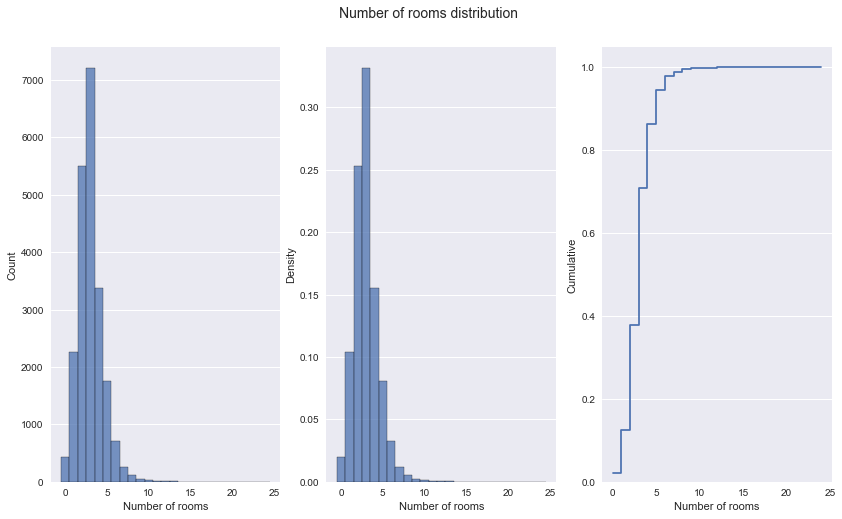

In [17]:
_ = plt.figure(figsize=(14,8))
plt.suptitle('Number of rooms distribution', 
             fontsize=14, y=0.95, 
             horizontalalignment='center')
bins=range(0,25,1)

plt.subplot(1,3,1)
sns.histplot(x=n_rooms, bins=bins, stat='count', discrete=True, 
             element='bars', cumulative=False, fill=True)
plt.xlabel('Number of rooms')
plt.ylabel('Count')
plt.grid(False, axis='x')

plt.subplot(1,3,2)
sns.histplot(x=n_rooms, bins=bins, stat='density', discrete=True, 
             element='bars', cumulative=False, fill=True)
plt.xlabel('Number of rooms')
plt.grid(False, axis='x')

plt.subplot(1,3,3)
sns.histplot(x=n_rooms, bins=bins, stat='probability', discrete=False, 
             element='step', cumulative=True, fill=False)
plt.xlabel('Number of rooms')
plt.ylabel('Cumulative')
plt.grid(False, axis='x')

In [18]:
test_results = find_best_fit_based_ks(n_rooms.values)
test_results

  0%|          | 0/101 [00:00<?, ?it/s]

{'distribution': None, 'd_statistic': 1, 'p_value': 0, 'params': None}

In [19]:
test_results = find_best_distribution(n_rooms)
test_results

  0%|          | 0/101 [00:00<?, ?it/s]

('burr',
 (785.3814634494588,
  1223.3321842970172,
  -980.5095295685915,
  973.9739767654628))

In [26]:
x_sorted = n_rooms.sort_values().values
pdf_x, pdf_y = calculate_pdf(distribution_name=test_results[0],
                             params=test_results[1],
                             size=n_rooms.shape[0])
edf = calculate_edf(data=n_rooms.values)
cdf = calculate_cdf(data=x_sorted, 
                    distribution_name=test_results[0], 
                    params=test_results[1])
pdf = pd.Series(pdf_x, pdf_y)

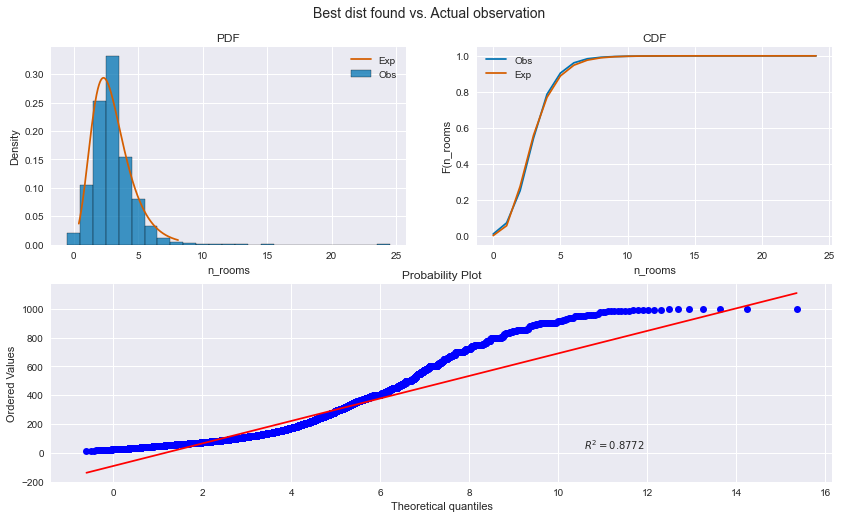

In [31]:
_ = plt.figure(figsize=(14,8))
feature_name = 'n_rooms'
plt.suptitle('Best dist found vs. Actual observation', 
             fontsize=14, y=0.95, 
             horizontalalignment='center')

plt.subplot(2,2,1)
sns.histplot(n_rooms, stat='density', discrete=True, 
             element='bars', label='Obs', color=colors[0])
sns.lineplot(x=pdf_x, y=pdf_y, label='Exp', color=colors[3])
plt.title('PDF')
plt.legend()

plt.subplot(2,2,2)
sns.lineplot(x=x_sorted, y=edf, label='Obs', color=colors[0]) # --> linewidth=4
sns.lineplot(x=x_sorted, y=cdf, label='Exp', color=colors[3])
plt.title('CDF')
plt.xlabel(feature_name)
plt.ylabel(f'F({feature_name}')
plt.legend()

plt.subplot(2,1,2)
a, b = stats.probplot(sq_mt_built, 
                      sparams=test_results[1],
                      dist=test_results[0],
                      fit=True, plot=plt, rvalue=True)